<a href="https://colab.research.google.com/github/kasekiguchi/python_lecture/blob/main/MPC_simple_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 12.5 MB/s eta 0:00:00


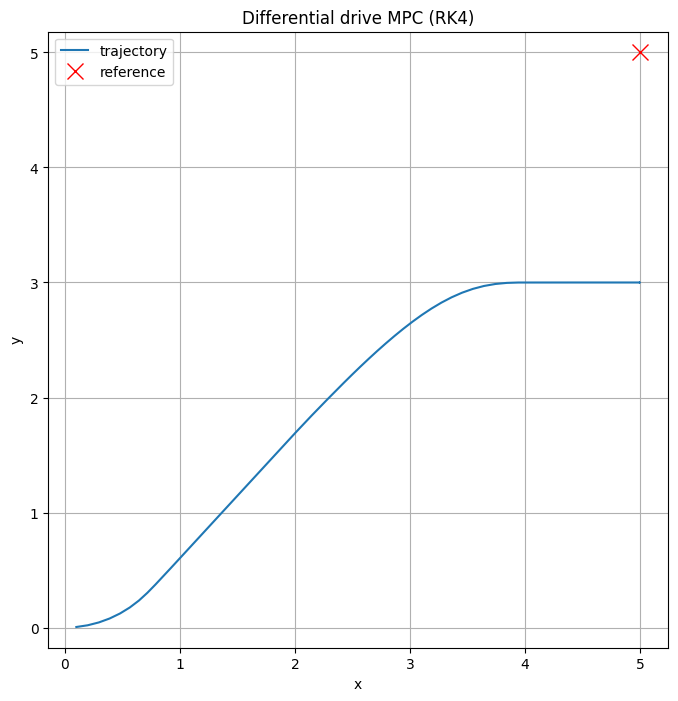

In [10]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

# Parameters
dt = 0.1           # sampling time
N = 20             # prediction horizon
nx = 3             # state: x, y, theta
nu = 2             # control: v, omega

Q = np.diag([1.0, 1.0, 0.1])   # state cost
R = np.diag([0.1, 0.1])         # input cost

# Reference
x_ref = np.array([5.0, 5.0, 0.0])

# ========== CasADi ODE & RK4 ==========
def unicycle_ode(x, u):
    theta = x[2]
    v = u[0]
    omega = u[1]
    dxdt = ca.vertcat(
        v * ca.cos(theta),
        v * ca.sin(theta),
        omega
    )
    return dxdt

def rk4_integrator(model, x, u, dt):
    k1 = model(x, u)
    k2 = model(x + dt/2 * k1, u)
    k3 = model(x + dt/2 * k2, u)
    k4 = model(x + dt * k3, u)
    x_next = x + dt/6*(k1 + 2*k2 + 2*k3 + k4)
    return x_next

# ========== MPC problem ==========
opti = ca.Opti()

# Decision variables
X = opti.variable(nx, N+1)
U = opti.variable(nu, N)

# Parameter for initial condition
X0 = opti.parameter(nx)

# Dynamics constraints with RK4
for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    x_next = X[:, k+1]
    xk1 = rk4_integrator(unicycle_ode, xk, uk, dt)
    opti.subject_to(x_next == xk1)

# y <= 3 の制約を追加
for k in range(N+1):
    opti.subject_to(X[1, k] <= 3)

# Objective function
cost = 0
for k in range(N):
    state_err = X[:,k] - x_ref
    input_use = U[:,k]
    cost += ca.mtimes([state_err.T, Q, state_err]) + ca.mtimes([input_use.T, R, input_use])
state_err = X[:,N] - x_ref
cost += ca.mtimes([state_err.T, Q, state_err])

opti.minimize(cost)

# Constraints on inputs
v_max, omega_max = 1.0, 1.0
opti.subject_to(opti.bounded(-v_max, U[0,:], v_max))
opti.subject_to(opti.bounded(-omega_max, U[1,:], omega_max))

# Initial condition
opti.subject_to(X[:,0] == X0)

# Solver settings
opts = {"ipopt.print_level":0, "print_time":0}
opti.solver("ipopt", opts)

# ========== Simulation loop ==========
sim_time = 20
steps = int(sim_time / dt)
history = []
u_history = []

x_current = np.array([0, 0, 0])   # initial position

for t in range(steps):
    opti.set_value(X0, x_current)
    opti.set_initial(X, np.tile(x_current.reshape(-1,1), (1,N+1)))
    opti.set_initial(U, np.zeros((nu,N)))

    try:
        sol = opti.solve()
        u_opt = sol.value(U[:,0])
    except RuntimeError:
        print("Solver failed at step", t)
        break

    # Forward simulate
    x_next = rk4_integrator(unicycle_ode, x_current, u_opt, dt)
    x_current = np.array(x_next).flatten()
    history.append(x_current.copy())
    u_history.append(u_opt.copy())

# ========== Plotting ==========
history = np.array(history)
plt.figure(figsize=(8,8))
plt.plot(history[:,0], history[:,1], label='trajectory')
plt.plot(x_ref[0], x_ref[1], 'rx', markersize=12, label='reference')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.axis('equal')
plt.title('Differential drive MPC (RK4)')
plt.show()


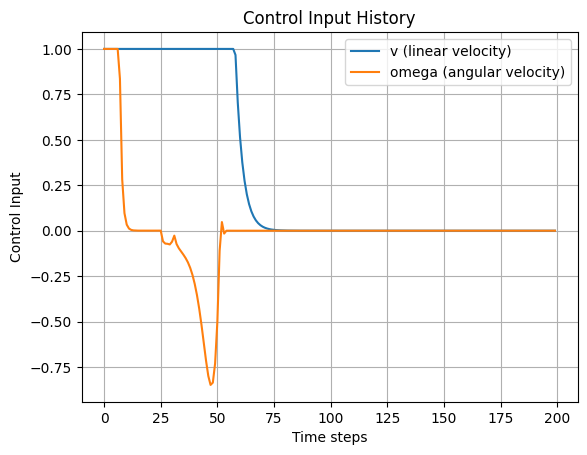

In [11]:
# prompt: plot u_history graph

u_history = np.array(u_history)
plt.figure()
plt.plot(u_history[:,0], label='v (linear velocity)')
plt.plot(u_history[:,1], label='omega (angular velocity)')
plt.xlabel('Time steps')
plt.ylabel('Control Input')
plt.title('Control Input History')
plt.legend()
plt.grid()
plt.show()